# Image Steganography

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
img_path = "images/inquiline_kea.jpg"
img = cv2.imread(img_path)
print(np.binary_repr(65, width=8)) # converts to binary representation

01000001


In [23]:
img.shape

(800, 1200, 3)

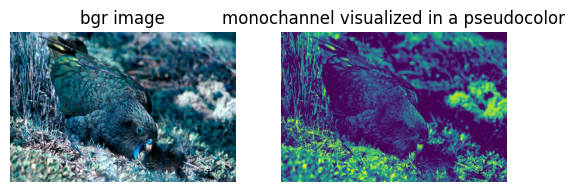

In [27]:
#edited = plt.imshow(img[:,:,::-1], cmap="gray")  # rgb channels are reversed

edited = np.copy(img) # deep copy the image
edited = edited[:,:,0]

# opencv uses bgr by default
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("bgr image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edited)
plt.title("monochannel visualized in a pseudocolor")
plt.axis('off')

plt.show()

In [28]:
edited.shape

# make sure the shape is height, width, 3 (3 is the num of channels)

(800, 1200)

In [29]:
# we will be using any one channel (in this case, only green channel)
b,g,r = cv2.split(img)

## Convert hidden message into binary

In [ ]:
def hidden_message_to_binary(hidden_message, end_character="!"): #end character marks when hidden message ends
    """
    Converts the hidden message to binary format
    hidden_message (string): the message to be encoded
    end character (character): the character which describes the end of sentence (Default is "!")
    """
    # append the end character
    hidden_message = hidden_message + end_character

    # convert the characters to their ascii values (as numbers)
    ascii_values = list(hidden_message.encode("ascii"))

    # convert the ascii values (numbers) to binary representation

    # join the elements in the list to form a string
    hidden_message_binary = "".join([np.binary_repr(ascii_code, width=8) for ascii_code in ascii_values])

    # convert it to a numpy array of dtype "int64"
    hidden_message_binary= np.array(list(hidden_message_binary), dtype="int64")

    return hidden_message_binary

In [33]:
short_msg = "lain"
short_msg.encode("ascii")
list(short_msg.encode("ascii")) # returns a list of ascii values

[108, 97, 105, 110]

In [36]:
# test the above function

sample_hidden_message = "A stressed-out businessman was running past a crowd of pigeons at 133% speed. Or, from our perspective: a normal-speed businessman was running past a crowd of pigeons, that were flying away at 75% speed."

binary_message = hidden_message_to_binary(sample_hidden_message)
# print(len(binary_message))
print(binary_message)

[0 1 0 ... 0 0 1]


In [37]:
print("Length of input sentence - ", len(sample_hidden_message))
print("Length of binary conversion - ", len(binary_message))
# num characters in ascii (assume 128 which is 8), converted into binary
# n = length of the message
# should be n*8 bits

# this includes the spaces within the sentence
assert len(binary_message) == 8*(len(sample_hidden_message)+1) # +1 for end character

Length of input sentence -  203
Length of binary conversion -  1632


## Extract the lowest bit plane

In [38]:
def bitPlaneSlicing(img, bit_plane):
    """
    img: gray scale image as input
    bit_plane: sliced place desired, also given as output
          1 -> least significant bit plane
          8 -> most significant bit plane
    """
    dec = np.binary_repr(img, width = 8) # img size is 300 x 400; with 8 bits
    # binary representation is applied per pixel per layer


    # 8 - bit_plane calculates which plane to extract, plane 8 should be the least significant,
    # represented by the index of 7
    # extracts the layer
    # str -> int format

    return int(dec[8-bit_plane])

bitPlaneSlicingVec = np.vectorize(bitPlaneSlicing)

In [39]:
# extracting the lowest bit plane out of the green channel of the image
l_plane = bitPlaneSlicingVec(g, 1)

In [40]:
l_plane.shape

(800, 1200)

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

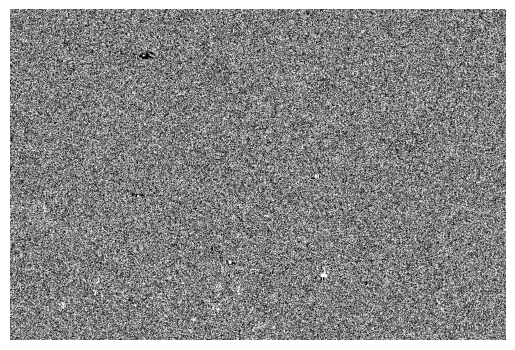

In [41]:
# least significant plane in grayscale

plt.imshow(l_plane, cmap="gray")
plt.axis('off')

## Mix the decoded message into the lowest bit plane

In [42]:
def add_code_to_bit_plane(bit_plane, binary_message):
    """
    Takes input as the bit plane and binary message
    and encodes the message to the bit plane.

    Arguments:
        bit_plane (np.ndarray): the bit plane which is returned by the func bitPlaneSlicing
        binary message (np.ndarray): the binary form of hidden message as returned by
        hidden_message_to_binary
    """
    # message length should probably < image size
    # directly replace first bits of image with message
    bit_plane_flattened = bit_plane.flatten()
    len_binary_coded = len(binary_message)
    bit_plane_flattened[:len_binary_coded] = binary_message
    bit_plane_coded = bit_plane_flattened.reshape(bit_plane.shape)
    return bit_plane_coded

In [43]:
l_plane_coded = add_code_to_bit_plane(l_plane, binary_message)

In [44]:
l_plane_coded.shape

(800, 1200)

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

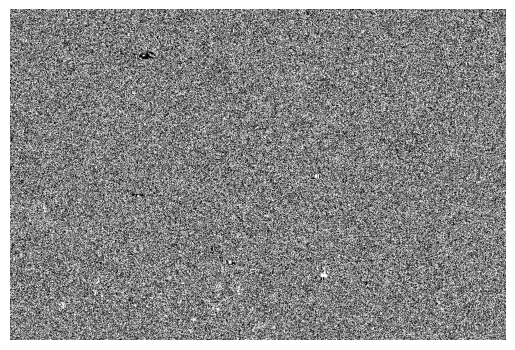

In [45]:
plt.imshow(l_plane_coded, cmap="gray")
plt.axis('off')

## Add the lowest bit plane back to the original image

In [47]:
def add_bit_plane_back_to_image(img, bit_plane):
    #Iterate over each pixel and change pixel value to binary using np.binary_repr() and store it in a list.
    lst = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
             lst.append(np.binary_repr(img[i][j] ,width=8)) # width = no. of bits

    # We have a list of strings where each string represents binary pixel value.
    # To extract bit planes we need to iterate over the strings and store the characters corresponding to bit planes into lists.
    # Multiply with 2^(n-1) and reshape to reconstruct the bit image.
    eight_bit_img = (np.array([int(i[0]) for i in lst],dtype = np.uint8) * 128).reshape(img.shape[0],img.shape[1])
    seven_bit_img = (np.array([int(i[1]) for i in lst],dtype = np.uint8) * 64).reshape(img.shape[0],img.shape[1])
    six_bit_img = (np.array([int(i[2]) for i in lst],dtype = np.uint8) * 32).reshape(img.shape[0],img.shape[1])
    five_bit_img = (np.array([int(i[3]) for i in lst],dtype = np.uint8) * 16).reshape(img.shape[0],img.shape[1])
    four_bit_img = (np.array([int(i[4]) for i in lst],dtype = np.uint8) * 8).reshape(img.shape[0],img.shape[1])
    three_bit_img = (np.array([int(i[5]) for i in lst],dtype = np.uint8) * 4).reshape(img.shape[0],img.shape[1])
    two_bit_img = (np.array([int(i[6]) for i in lst],dtype = np.uint8) * 2).reshape(img.shape[0],img.shape[1])

    # add them all together!
    final_image = eight_bit_img + seven_bit_img + six_bit_img + five_bit_img + four_bit_img + three_bit_img + two_bit_img + l_plane_coded.astype("uint8")
    return final_image


In [48]:
final_image_g = add_bit_plane_back_to_image(g, l_plane_coded)

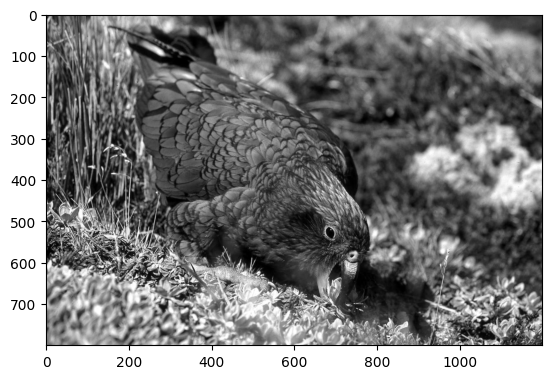

In [49]:
plt.imshow(final_image_g, cmap="gray")

In [50]:
final_image_bgr = cv2.merge((b, final_image_g, r))

In [ ]:
cv2.imwrite("images/coded_image.png", final_image_bgr)

True

In [53]:
final_image_bgr.shape

(800, 1200, 3)

## Get message from the coded image

In [54]:
def binary_repr_to_ch(binary_array):
    binary_value = "".join(binary_array.astype('str'))
    ascii_code = int(binary_value, 2)
    character = chr(ascii_code)
    return character

In [55]:
def get_message_from_plane(plane, end_character = "!"):
    # all pixel values within a particular plane within a colour channel
    plane_flatten = plane.flatten()
    plane_flatten = plane_flatten[:len(plane_flatten) - len(plane_flatten)%8] # make sure array is a multiple of 8
    # calculates reminder and subtracts it away from length of the flattened plane
    plane_reshaped = plane_flatten.reshape(-1, 8) # make the total number of columns 8
    # with an arbitrary number of rows, to represent binary structure

    sentence = []
    for binary_repr in plane_reshaped:
        character = binary_repr_to_ch(binary_repr)
        if character == end_character:
            break
        sentence.append(character)

    return "".join(sentence)


In [56]:
def decode_image(image, end_character="!"):
    """
    image: single channel image, where message is being hidden in the
            lowest bit plane
    end character: the character denoting the end of hidden message
    """
    _, second_channel, _ = cv2.split(image)
    lowest_bit_plane = bitPlaneSlicingVec(second_channel, 1)

    message = get_message_from_plane(lowest_bit_plane)

    return message


### Read the saved image

In [58]:
encoded_img = cv2.imread("images/coded_image.png")

In [59]:
encoded_img.shape

(800, 1200, 3)

In [60]:
decode_image(encoded_img)

'A stressed-out businessman was running past a crowd of pigeons at 133% speed. Or, from our perspective: a normal-speed businessman was running past a crowd of pigeons, that were flying away at 75% speed.'

recap:
- have image
- pick a particular channel
- pick the least significant plane
- rewrite the least significant plane with encoded message
- this message should be converted from letters to ascii to binary.